We have here two goals to accomplish:
1. Investigate how more data helps performance
2. Bifurcation diagram

In [3]:
import sys
sys.path.append("./source")

import pandas as pd
import NovakTyson
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
# Number of time series to generate
N = 100

# cyclin synthesis and degradation are inhibited
time_points, novak_data = NovakTyson.simulate_custom(cyclin=0, MPF=0, tlast=1500, k1=0, v2_1=0, v2_2=0, cdc25_total=5)
data_numpy = np.zeros((100, novak_data.shape[1], novak_data.shape[2]))

cyclin_list = np.random.uniform(0, 22, N)
for i in range(N):
    # cyclin synthesis and degradation are inhibited
    _, data_numpy[i, :, :] = NovakTyson.simulate_custom(cyclin = cyclin_list[i], MPF=0, tlast=1500, k1=0, v2_1=0, v2_2=0, cdc25_total=5)
    
# replace all values that are numerically zero
data_numpy = np.where(data_numpy < 1e-4, 0, data_numpy)

In [16]:
# create a data frame
df = pd.DataFrame(data_numpy[0])
df.columns = ['cyclin', 'MPF', 'preMPF', 'cdc25P', 'wee1P', 'IEP', 'APC']
df['Strain'] = [0] * df.shape[0]
df['Time'] = time_points
for j in range(1, N):
    dummy = pd.DataFrame(data_numpy[j])
    dummy.columns = ['cyclin', 'MPF', 'preMPF', 'cdc25P', 'wee1P', 'IEP', 'APC']
    dummy['Strain'] = [j] * dummy.shape[0]
    dummy['Time'] = time_points
    df = pd.concat([df, dummy])

display(df)

#df.set_index('Strain', inplace=True)

,cyclin,MPF,preMPF,cdc25P,wee1P,IEP,APC,Strain,Time
0,19.530800,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0,0.0
1,17.688801,1.666852,0.175146,0.003424,0.001745,0.972501,0.993766,0,0.2
2,16.048407,2.853391,0.629002,0.012275,0.006250,0.950123,0.991500,0,0.4
3,14.582735,3.675332,1.272732,0.024819,0.012616,0.931703,0.990255,0,0.6
4,13.269324,4.222717,2.038758,0.039759,0.020167,0.916059,0.989434,0,0.8
...,...,...,...,...,...,...,...,...,...
7495,0.000000,1.318968,16.453001,0.348149,0.139010,0.002108,0.002092,99,1499.0
7496,0.000000,1.318968,16.453001,0.348149,0.139010,0.002108,0.002092,99,1499.2
7497,0.000000,1.318968,16.453001,0.348149,0.139010,0.002108,0.002092,99,1499.4
7498,0.000000,1.318968,16.453001,0.348149,0.139010,0.002108,0.002092,99,1499.6


In [17]:
df.describe()

,cyclin,MPF,preMPF,cdc25P,wee1P,IEP,APC,Strain,Time
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,0.016745,1.943852,9.129339,0.619902,0.137353,0.099064,0.107292,49.500000,749.900000
std,0.352752,4.031346,4.898603,1.426091,0.226319,0.293270,0.300172,28.866089,433.012987
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.290220,5.740200,0.060324,0.029430,0.000398,0.000396,24.750000,374.950000
50%,0.000000,0.579441,8.406591,0.128105,0.059510,0.000828,0.000873,49.500000,749.900000
75%,0.000000,1.069172,13.907000,0.264881,0.111833,0.001643,0.001796,74.250000,1124.850000
max,21.994560,15.404834,19.983294,4.962987,0.827686,1.000000,1.000000,99.000000,1499.800000


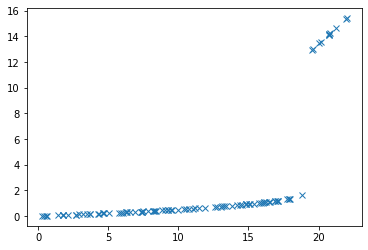

In [19]:
# plot the bifurcation diagram from data

mpf_list = [data_numpy[i][-1][1] for i in range(N)]
plt.plot(cyclin_list, mpf_list, 'x')

In [20]:
import train_lmmNet
import predict_lmmNet
import tensorflow as tf

# select first 99 as training
train_data = tf.convert_to_tensor(data_numpy[1:,:,:], dtype=tf.float32)
test_data = tf.convert_to_tensor(data_numpy[0,:,:], dtype=tf.float32)

model = train_lmmNet.train_easy(time_points, train_data)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



NameError: name 'odeint' is not defined

In [ ]:
predicted_test = odeint(lambda x, t: predict_lmmNet.predict_fn(x, t, model), test_data[0,0,:], time_points)